# Classification.ipynb
By: **SHAWN VOSBURG** (260743167)   
Date: October 22th, 2018  
Class: ECSE415  

## For this task, you are given a set of training images (check ‘dataset’ folder): five logos of ‘Ford’ and five logos of ‘Volkswagen’ (see Figure 2). You are also given two real-world test images, one for each manufacturer. Use class label 1 for ‘Ford’ and -1 for ‘Volkswagen’. Build a classification system using HoG features as follows:


# Training
## 1. Resize the training images to 128 × 128.

Size of ford image: (128, 128, 3)
Size of VW image: (128, 128, 3)


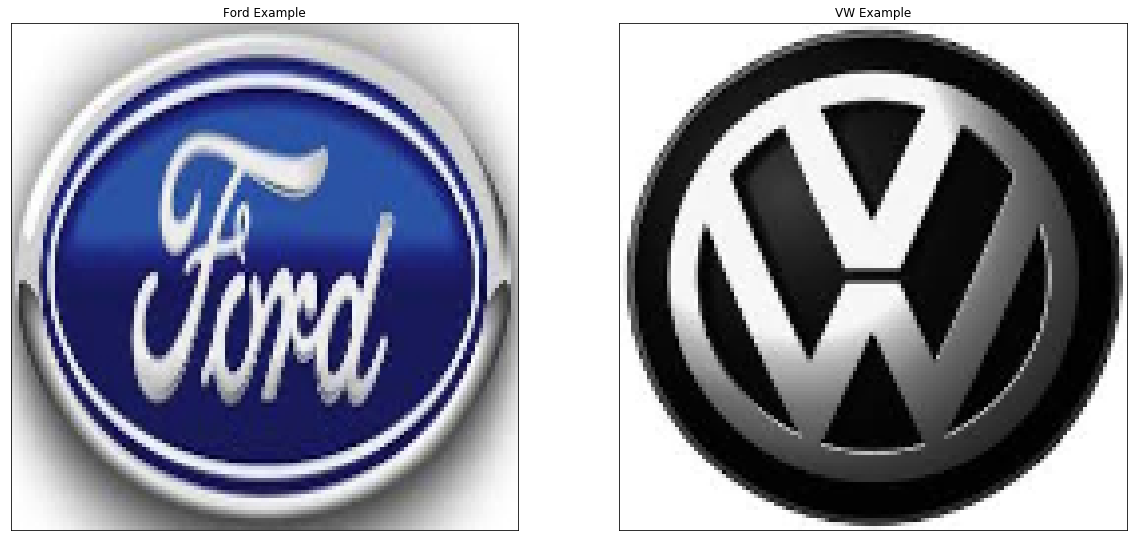

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier


#import images
folder = "./dataset/"
imageTrain = os.listdir(folder)
size = (128,128)
fordTrain, vwTrain, fordIden, vwIden = [],[],[],[]
for i in range(0,len(imageTrain)):
    if "test" in imageTrain[i]:
        continue;
    if "ford" in imageTrain[i]:
        ford = cv2.imread(folder +imageTrain[i])
        ford = cv2.cvtColor(ford, cv2.COLOR_BGR2RGB)
        ford = cv2.resize(ford,size)
        fordTrain.append(ford)
        fordIden.append("FORD")
    if "volks" in imageTrain[i]:
        vw = cv2.imread(folder +imageTrain[i])
        vw = cv2.cvtColor(vw, cv2.COLOR_BGR2RGB)
        vw = cv2.resize(vw,size)
        vwTrain.append(vw)
        vwIden.append("VOLKS")
        
numFordTrain = len(fordTrain)
numVWTrain = len(vwTrain)
        
print("Size of ford image:", fordTrain[1].shape)
print("Size of VW image:", vwTrain[2].shape)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(fordTrain[1])
plt.title("Ford Example"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(vwTrain[2])
plt.title("VW Example"), plt.xticks([]), plt.yticks([])
plt.show()

## 2. Compute HoG features of size (32,32,8). Apply blocknorm in 4 × 4 cell neighborhood. (Deduce values of other required variables.) 

Size of Ford's Hog Features (5, 32, 32, 8)
Size of Volks's Hog Features (5, 32, 32, 8)


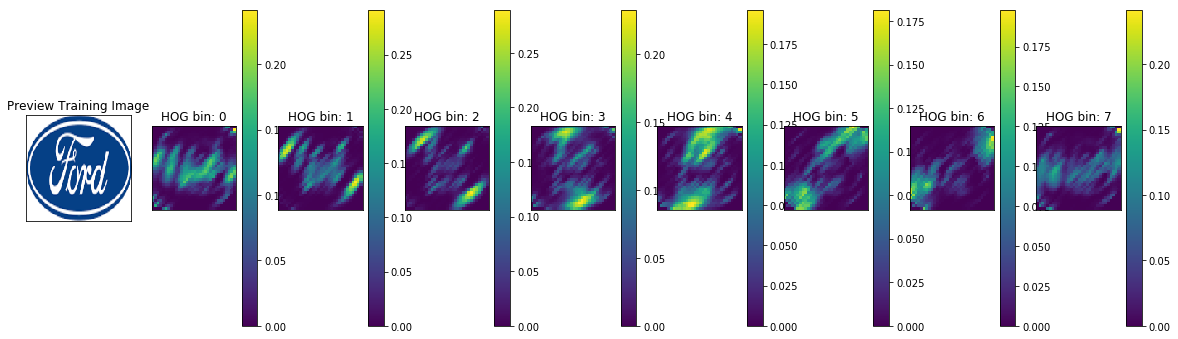

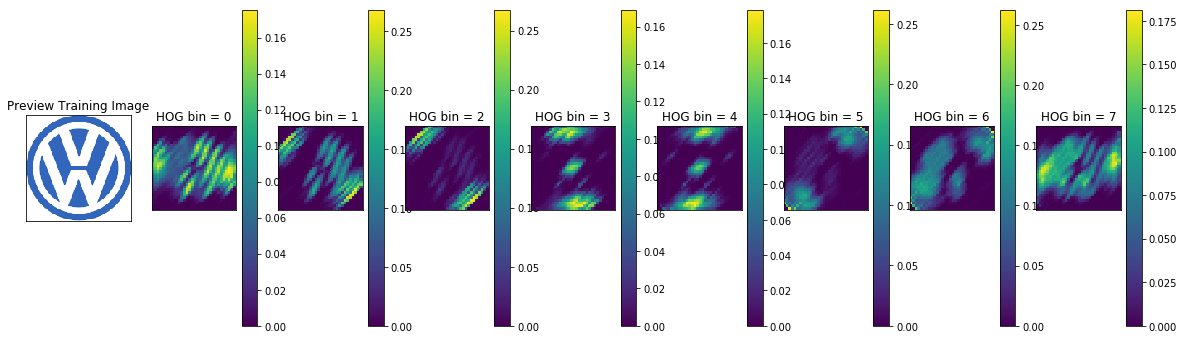

In [4]:
#Deducing values of required variables. 
#Since HoG features must be (32,32,8) in size, there must be a 2D-array of 32x32 cells with each containing 8 bins.
#Since image is 128x128, each cell's side is 128/32 = 4px in length. (1 cell = 4x4 pixels)
#Blocks must cover a 4x4 cell neighborhood (Assume 50% overlap between blocks). 

cell_size = (4,4)  # h x w in pixels
block_size = (4,4)  # h x w in cells
nbins = 8  # number of orientation bins

def HoGFromImages(imgArr,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        imgArr = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """
    arr = []
    for img in imgArr:
        #create final return array
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                          img.shape[0] // cs[0] * cs[0]),
                                _blockSize=(bs[1] * cs[1],
                                            bs[0] * cs[0]),
                                _blockStride=(cs[1], cs[0]),
                                _cellSize=(cs[1], cs[0]),
                                _nbins=nb)

        n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - bs[1] + 1,
                                n_cells[0] - bs[0] + 1,
                                bs[0], bs[1], nb) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.

        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        #Add each contributions to the histogram.
        for off_y in range(bs[0]):
            for off_x in range(bs[1]):
                gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                          off_x:n_cells[1] - bs[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                           off_x:n_cells[1] - bs[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        arr = np.append(arr,gradients)
    return arr.reshape(len(imgArr),gradients.shape[0],gradients.shape[1],gradients.shape[2])

hogFord = HoGFromImages(fordTrain,cell_size,block_size,nbins)
hogVW = HoGFromImages(vwTrain,cell_size,block_size,nbins)
print("Size of Ford's Hog Features", hogFord.shape)
print("Size of Volks's Hog Features", hogVW.shape)

# Preview
plt.figure(figsize = (20,20))
plt.subplot(191)
plt.imshow(fordTrain[3], cmap='gray')
plt.title("Preview Training Image"), plt.xticks([]), plt.yticks([])
for bin in range(nbins):
    plt.subplot(192+bin)
    plt.pcolor(hogFord[4][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

plt.figure(figsize = (20,20))
plt.subplot(291)
plt.imshow(vwTrain[0], cmap='gray')
plt.title("Preview Training Image"), plt.xticks([]), plt.yticks([])
for bin in range(nbins):
    plt.subplot(292+bin)
    plt.pcolor(hogVW[0][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin = " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

## 3. Fit a nearest neighbor classifier with three neighbors. Use K N ei g h b o r s Cl a s si fi e r from s k l e a r n library. 

In [5]:
#creating copies of training image array
hogFordPts = hogFord.copy()
hogVWPts = hogVW.copy()

#Create KNN object
knn = KNeighborsClassifier(n_neighbors=3)

#Reshaping so that both hog features array have dimension order of 2
hogFordPts = np.reshape(hogFordPts,(numFordTrain,-1))
hogVWPts = np.reshape(hogVWPts,(numVWTrain,-1))

#build identification arrays
fordIden = np.asarray(fordIden)
vwIden = np.asarray(vwIden)


#fitting hogpoints. 
hogPts = np.append(hogFordPts,hogVWPts)
hogPts = np.reshape(hogPts,(numFordTrain+ numVWTrain, -1))
hogIden = np.append(fordIden,vwIden)
hogIden = np.reshape(hogIden,(numFordTrain+ numVWTrain))
knn.fit(hogPts, hogIden)




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

## 4. Resize test images to 128 × 128.

Ford test image size:  (128, 128, 3)
VW test image size:  (128, 128, 3)


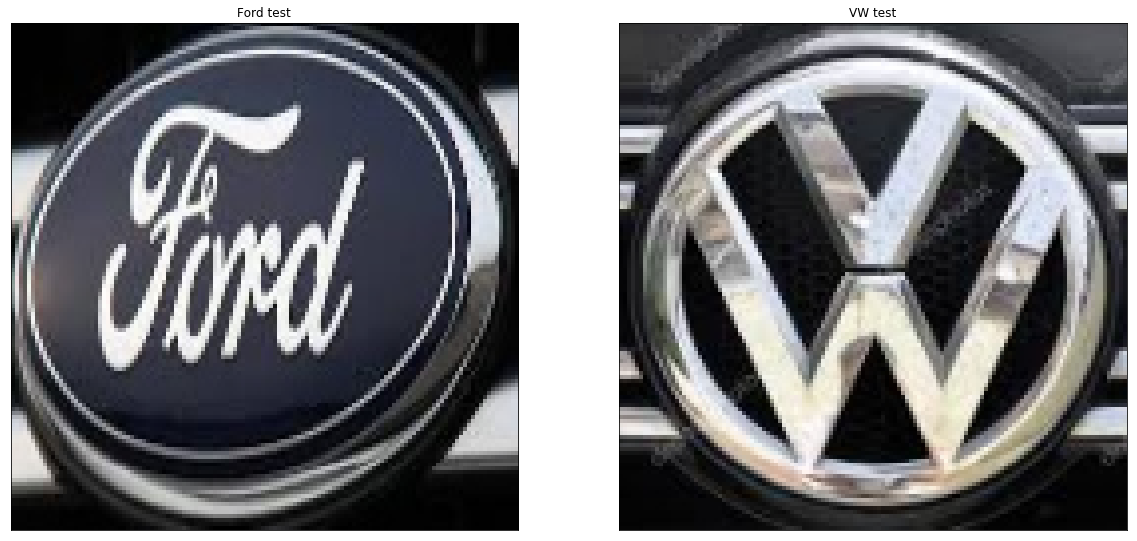

In [6]:
#import images. Resize
size = (128,128)
fordTest = cv2.imread("./dataset/ford_test.jpeg")
fordTest = cv2.cvtColor(fordTest, cv2.COLOR_BGR2RGB)
fordTest = cv2.resize(fordTest,size)
vwTest = cv2.imread("./dataset/volks_test.jpeg")
vwTest = cv2.cvtColor(vwTest, cv2.COLOR_BGR2RGB)
vwTest = cv2.resize(vwTest,size)

#print size of images
print("Ford test image size: ",fordTest.shape)
print("VW test image size: ",vwTest.shape)


plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(fordTest)
plt.title("Ford test"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(vwTest)
plt.title("VW test"), plt.xticks([]), plt.yticks([])
plt.show()

## 5. Compute HoG features similar to what was done during training.

In [7]:
#compute hog
cell_size = (4,4)  # h x w in pixels
block_size = (4,4)  # h x w in cells
nbins = 8  # number of orientation bins
imgs = [fordTest,vwTest]
hogTest = HoGFromImages(imgs,cell_size,block_size,nbins)
hogFordTest = hogTest[0]
hogVWTest = hogTest[1]

#print size of hog descriptors
print("Ford's HoG descriptor size: ",hogFordTest.shape)
print("VW's HoG descriptor size: ",hogVWTest.shape)



Ford's HoG descriptor size:  (32, 32, 8)
VW's HoG descriptor size:  (32, 32, 8)


## 6.  Display the features for both test images.


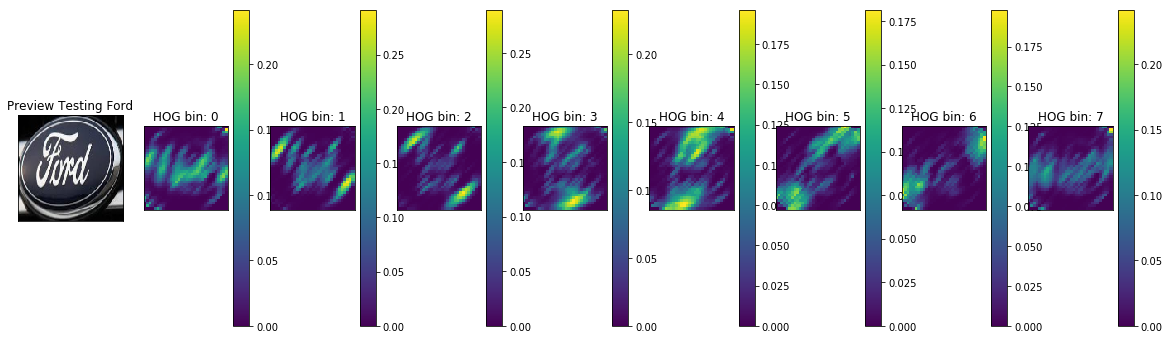

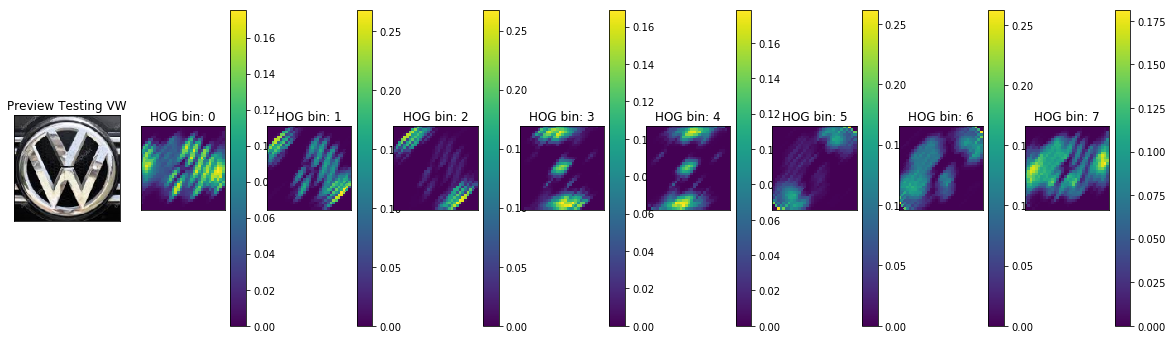

In [8]:
# Preview
plt.figure(figsize = (20,20))
plt.subplot(191)
plt.imshow(fordTest, cmap='gray')
plt.title("Preview Testing Ford"), plt.xticks([]), plt.yticks([])
for bin in range(nbins):
    plt.subplot(192+bin)
    plt.pcolor(hogFord[4][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

plt.figure(figsize = (20,20))
plt.subplot(291)
plt.imshow(vwTest, cmap='gray')
plt.title("Preview Testing VW"), plt.xticks([]), plt.yticks([])
for bin in range(nbins):
    plt.subplot(292+bin)
    plt.pcolor(hogVW[0][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

## 7. Classify the test images using the classifier built above. 

In [9]:
hogFordTest = hogFordTest.reshape(1,-1)
predFordTest = knn.predict(hogFordTest)
hogVWTest = hogVWTest.reshape(1,-1)
predVWTest = knn.predict(hogVWTest)

print("The Ford test image has been classified as: ", predFordTest[0])
print("The VOLKS test image has been classified as: ", predVWTest[0])

The Ford test image has been classified as:  FORD
The VOLKS test image has been classified as:  VOLKS


# 3.2 REASONING Questions

## 1. Will HoG work if images of logos undergo random rotation? If yes, which property of HoG avails this feature? If not, discuss the sequence of computer vision technique(s) that can be used in order to regain uniform orientation of the logos.

Answer: HoG will not reproduce the same descriptors if the logos undergo random rotation. The reason is that HoG is very sensible to rotations. HoG works by calculating the orientation of gradients and their magnitude. Rotating the logo would produce the orientation of gradients to change and would not produce HoG descriptors. To regain uniform orientation of the logos, a truth image is needed to provide correct orientation. Homography can then be calculated between all rotated image and the truth image using SIFT/SURF/ORB keypoints. The correct orientation would be established and then HoG could be computed without worry. 

## 2.Consider that you are given a large dataset with three types of images: variable sized squares with either or both diagonals drawn (see Figure 3). How many and which directions of the gradient are sufficient in order to correctly classify the images into three categories?

Answer: Since there are 2 diagonals, with each a distinct direction, only 2 gradient directions are needed (one for each diagonal). The two HoG bins would contain the direction of the gradients. Their directions would be along the normals of the diagonals. The three categories would then be labelled as "the images with a HoG containing diagonal from top-left to bottom-right", "the images with a HoG containing diagonal from top-right to bottom-left" and "the images with a HoG containing both digonal"